# NBA con Redes Neuronales

El objetivo de este trabajo es hacer una predicción de los partidos de la NBA usando datos de la temporada pasada y la actual previamente extraidos usando web scraping.

Para esta predicción se usarán redes neuronales 

# Lectura de datos

In [ ]:
import pandas as pd
import missingno as msno
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive

ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
%cd '{ROOT}/MyDrive/'
%pwd 

/content/drive/MyDrive


'/content/drive/MyDrive'

In [ ]:
df = pd.read_csv("nba_games_valid.csv",index_col = 0)

# Preprocesamiento

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df = df.sort_values('date')
df = df.reset_index(drop = True)

In [ ]:
del df["mp.1"]
del df["mp_opp.1"]
del df["index_opp"]

In [ ]:
e = [x for x in df.columns]

In [ ]:
vars = e[:20],e[69:72],e[141:146]

In [ ]:
import itertools
vars =list(itertools.chain.from_iterable(vars))

In [ ]:
df = df[vars]

## Nulos

<Axes: >

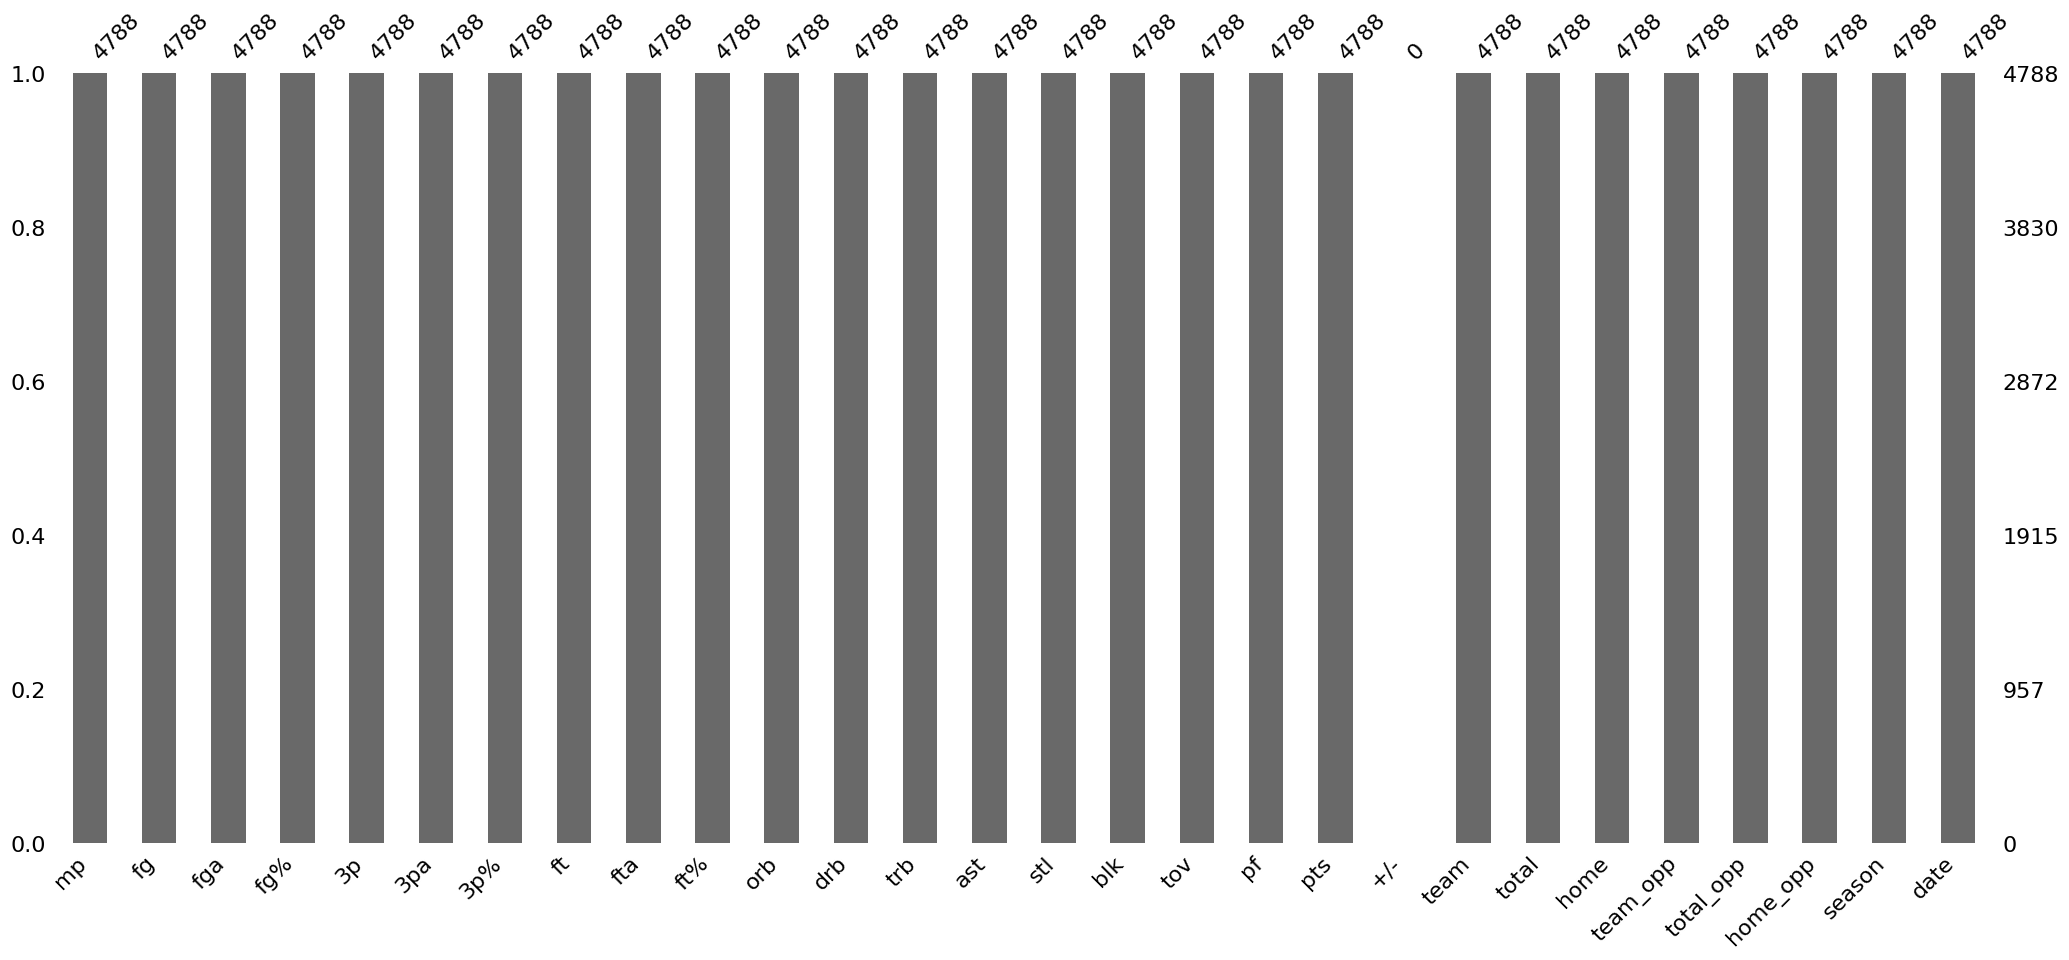

In [ ]:
msno.bar(df)

In [ ]:
nulls = pd.isnull(df).sum()

In [ ]:
nulls = nulls[nulls > 0]

In [ ]:
valid_columns = df.columns[~df.columns.isin(nulls.index)]

In [ ]:
valid_columns

Index(['mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%', 'orb',
       'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'team', 'total',
       'home', 'team_opp', 'total_opp', 'home_opp', 'season', 'date'],
      dtype='object')

In [ ]:
df = df[valid_columns].copy()

In [ ]:
df = df.drop(columns = ['pts','mp','home_opp'])

## Creacion del Target

El target en este caso se trata de el score de la siguiente semana

In [ ]:
def add_target(team):
    team["target"] = team["total"].shift(-1)
    return team

df = df.groupby("team", group_keys=False).apply(add_target)

In [ ]:
df = df.dropna()

In [ ]:
df.drop(columns=["date"], inplace = True)

<ipython-input-21-601cbe3a9d6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["date"], inplace = True)


## Escalamiento

In [ ]:
df.head()

,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,...,blk,tov,pf,team,total,home,team_opp,total_opp,season,target
0,36.0,81.0,0.444,5.0,27.0,0.185,21.0,26.0,0.808,7.0,...,8.0,21.0,17.0,WAS,98,0,TOR,83,2022,135.0
1,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,...,4.0,19.0,21.0,TOR,83,1,WAS,98,2022,115.0
2,35.0,86.0,0.407,9.0,29.0,0.310,18.0,23.0,0.783,13.0,...,6.0,16.0,20.0,ORL,97,0,SAS,123,2022,96.0
3,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,...,3.0,8.0,22.0,SAS,123,1,ORL,97,2022,96.0
4,34.0,91.0,0.374,7.0,35.0,0.200,11.0,18.0,0.611,15.0,...,2.0,14.0,15.0,OKC,86,0,UTA,107,2022,91.0


In [ ]:
df_ = df.copy()
num_d = df_.select_dtypes(exclude=['object'])
num_d.drop(columns = 'target',inplace = True)
cat_d = df_.select_dtypes(exclude=["float64","int64"])
target_d = df_[["target"]]

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# StandardScaler
num_transformer = StandardScaler()
num_transformed = num_transformer.fit_transform(num_d)

# OneHotEncoder 
cat_transformer = OneHotEncoder()
cat_transformed = cat_transformer.fit_transform(cat_d)


cat_feature_names = cat_transformer.get_feature_names_out(cat_d.columns)

target_transformer = StandardScaler()
target_transformed = target_transformer.fit_transform(target_d)

num_d_transformed = pd.DataFrame(num_transformed, columns=num_d.columns)
cat_d_transformed = pd.DataFrame(cat_transformed.toarray(), columns=cat_feature_names)
target_d_transformed = pd.DataFrame(target_transformed, columns=target_d.columns)


df_transformed = pd.concat([num_d_transformed, cat_d_transformed, target_d_transformed], axis=1)


In [ ]:
df_transformed.head()

,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,...,team_opp_ORL,team_opp_PHI,team_opp_PHO,team_opp_POR,team_opp_SAC,team_opp_SAS,team_opp_TOR,team_opp_UTA,team_opp_WAS,target
0,-0.974621,-0.977927,-0.431683,-1.926518,-1.136288,-2.051179,0.571999,0.473297,0.289201,-0.855620,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.839704
1,-2.128978,1.273695,-2.859602,-1.404129,-0.102548,-1.798984,-0.290131,-0.102391,-0.519000,2.208577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.224538
2,-1.167014,-0.274295,-1.097113,-0.881739,-0.840934,-0.550017,0.054721,0.041531,0.039756,0.676478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.309870
3,1.526487,1.414421,0.575454,0.163041,-0.693257,0.927126,-0.979834,-0.678079,-1.117667,0.676478,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.309870
4,-1.359407,0.429337,-1.690604,-1.404129,0.045129,-1.871039,-1.152260,-0.678079,-1.676423,1.187178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.713661


In [ ]:
TargetVariable=['target']
Predictors=[x for x in df_transformed.columns if x not in TargetVariable]
 
X=df_transformed[Predictors].values
y=df_transformed[TargetVariable].values

# Regresion con NN

# Modelado 

## Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Baseline

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#  ANN model
model = Sequential()

#  Input layer 
model.add(Dense(units=8, input_dim=81, kernel_initializer='he_uniform', activation='relu', kernel_regularizer=l2(0.001)))

#  Second layer
model.add(Dense(units=64, kernel_initializer='he_uniform', activation='relu', kernel_regularizer=l2(0.001)))

# Dropout layer para prevenir sobreajuste
model.add(Dropout(0.3))

# Third layer para aumentar la complejidad de la red
model.add(Dense(units=128, kernel_initializer='he_uniform', activation='relu', kernel_regularizer=l2(0.001)))

# Output, se trata de una sola neurona
model.add(Dense(1, kernel_initializer='normal'))

early_stopping = EarlyStopping(monitor='loss', patience=3)


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse', 'mae'])



# Hiperparametrización

Después de nuestro baseline, haremos un ajuste de hiperparámetros para mejorar nuestros resultados

In [ ]:
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def create_model(units_1=32, units_2=16, dropout_rate=0.5, units_3=8, 
                 learning_rate=0.001, l2_reg=0.001):
    # create ANN model
    model = Sequential()
    # Defining the Input layer 
    model.add(Dense(units=units_1, input_dim=81, kernel_initializer='he_uniform',
                    activation='relu', kernel_regularizer=l2(l2_reg)))
    # Defining the Second layer of the model
    model.add(Dense(units=units_2, kernel_initializer='he_uniform',
                    activation='relu', kernel_regularizer=l2(l2_reg)))
    # Adding a dropout layer to prevent overfitting
    model.add(Dropout(dropout_rate))
    # Adding a third layer to increase model complexity
    model.add(Dense(units=units_3, kernel_initializer='he_uniform',
                    activation='relu', kernel_regularizer=l2(l2_reg)))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, 
                  metrics=['mse', 'mae'])
    return model

def find_best_params(X, y):
    # Create a KerasRegressor
    model = KerasRegressor(build_fn=create_model, verbose=0)
    # Define hyperparameters to search
    param_dist = {
        'units_1': [16, 32, 64, 128],
        'units_2': [8, 16, 32, 64],
        'dropout_rate': np.arange(0.1, 0.6, 0.1),
        'units_3': [4, 8, 16],
        'learning_rate': [0.0001, 0.001, 0.01],
        'l2_reg': [0.001, 0.01, 0.1]
    }
    # Randomized search with cross validation
    search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                n_iter=20, cv=3, verbose=2, 
                                random_state=42, n_jobs=-1)
    search.fit(X, y, callbacks=[early_stopping])
    # Return the best hyperparameters and the best score
    return search.best_params_, search.best_score_


In [ ]:
best_par, best_sco = find_best_params(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


<ipython-input-29-537d570fce1a>:30: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [ ]:
best_par

{'units_3': 8,
 'units_2': 64,
 'units_1': 128,
 'learning_rate': 0.01,
 'l2_reg': 0.1,
 'dropout_rate': 0.30000000000000004}

In [ ]:
best_sco

-1.0178025960922241

# Entrenamiento con mejores parámetros

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=40)

Epoch 1/150
77/77 [==============================] - 1s 6ms/step - loss: 1.1088 - mse: 1.0073 - mae: 0.7940 - val_loss: 1.1115 - val_mse: 1.0201 - val_mae: 0.8149
Epoch 2/150
77/77 [==============================] - 0s 3ms/step - loss: 1.0875 - mse: 1.0037 - mae: 0.7924 - val_loss: 1.0926 - val_mse: 1.0159 - val_mae: 0.8132
Epoch 3/150
77/77 [==============================] - 0s 3ms/step - loss: 1.0624 - mse: 0.9910 - mae: 0.7879 - val_loss: 1.0727 - val_mse: 1.0061 - val_mae: 0.8080
Epoch 4/150
77/77 [==============================] - 0s 4ms/step - loss: 1.0502 - mse: 0.9870 - mae: 0.7863 - val_loss: 1.0589 - val_mse: 0.9989 - val_mae: 0.8051
Epoch 5/150
77/77 [==============================] - 0s 3ms/step - loss: 1.0351 - mse: 0.9774 - mae: 0.7828 - val_loss: 1.0500 - val_mse: 0.9945 - val_mae: 0.8032
Epoch 6/150
77/77 [==============================] - 0s 3ms/step - loss: 1.0269 - mse: 0.9734 - mae: 0.7819 - val_loss: 1.0381 - val_mse: 0.9864 - val_mae: 0.7992
Epoch 7/150
77/77 [===

In [ ]:
Predictions=model.predict(X_test)

30/30 [==============================] - 0s 2ms/step


In [ ]:
model_score = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print("Test MSE:", model_score[1])

30/30 [==============================] - 0s 2ms/step - loss: 1.4972 - mse: 1.4152 - mae: 0.9329
Test MSE: 1.4151511192321777


# Probamos y guardamos el modelo

In [ ]:
import pandas as pd


Predictions_inv = target_transformer.inverse_transform(Predictions)
y_test_orig_inv = target_transformer.inverse_transform(y_test)


df_pred = pd.DataFrame(Predictions_inv, columns=['Predictions'])
df_y_test = pd.DataFrame(y_test_orig_inv, columns=['y_test'])

ResultsData = pd.concat([df_pred, df_y_test], axis=1)

In [ ]:
X_test_orig = pd.DataFrame(num_transformer.inverse_transform(X_test[:, :num_d.shape[1]]),
                           columns=num_d.columns)
X_test_cat = cat_transformer.inverse_transform(X_test[:, num_d.shape[1]:])
X_test_cat = pd.DataFrame(X_test_cat, columns=cat_d.columns)
X_test_orig = pd.concat([X_test_orig, X_test_cat], axis=1)

In [ ]:
ResultsData['team'] = df.loc[X_test_orig.index, 'team'].values
ResultsData['team_opp'] = df.loc[X_test_orig.index, 'team_opp'].values

In [ ]:
ResultsData = ResultsData.reindex(columns=['team', 'team_opp', 'y_test', 'Predictions'])

In [ ]:
ResultsData

,team,team_opp,y_test,Predictions
0,WAS,TOR,97.0,102.815346
1,TOR,WAS,121.0,116.302521
2,ORL,SAS,115.0,111.617752
3,SAS,ORL,116.0,105.738945
4,OKC,UTA,118.0,129.925079
...,...,...,...,...
947,DEN,LAC,103.0,99.490875
948,CHI,IND,88.0,111.707436
949,IND,CHI,116.0,96.553162
950,SAS,DET,105.0,102.213951


In [ ]:
import keras

In [ ]:
pd.to_pickle(model, "NBA.pkl")
model.save('NBA.h5')

# Pruebas

## Librerias

In [ ]:
import pandas as pd
import itertools
from google.colab import drive
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import keras

## Preprocesado

In [ ]:
ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)
%cd '{ROOT}/MyDrive/'
%pwd 
df = pd.read_csv("nba_games_pruebas_2.csv",index_col = 0)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
df.head()

,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won
0,240.0,240.0,31.0,83.0,0.373,8.0,37.0,0.216,18.0,19.0,...,100.0,45.6,237.0,105.0,BOS,112,1,2023,2023-05-14,False
1,240.0,240.0,41.0,87.0,0.471,15.0,33.0,0.455,15.0,18.0,...,29.6,40.1,200.0,129.0,PHI,88,0,2023,2023-05-14,True
2,240.0,240.0,39.0,103.0,0.379,13.0,48.0,0.271,10.0,14.0,...,12.3,32.6,300.0,120.0,LAL,122,1,2023,2023-05-12,False
3,240.0,240.0,39.0,75.0,0.520,13.0,26.0,0.500,31.0,42.0,...,20.0,35.8,208.0,135.0,GSW,101,0,2023,2023-05-12,True
4,240.0,240.0,27.0,71.0,0.380,10.0,35.0,0.286,28.0,32.0,...,100.0,31.2,273.0,109.0,MIA,96,1,2023,2023-05-12,False


In [ ]:
df.date.max()

Timestamp('2023-05-23 00:00:00')

In [ ]:
df.date.min()

Timestamp('2023-05-14 00:00:00')

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
from datetime import timedelta

limite = df.date.max()-timedelta(days = 10) 

df=df[df.date>=limite]

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.reset_index(drop = True)
del df["mp.1"]
del df["mp_opp.1"]
del df["index_opp"]
e = [x for x in df.columns]
vars = e[:20],e[69:72],e[141:146]

vars =list(itertools.chain.from_iterable(vars))
df = df[vars]
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]
valid_columns = df.columns[~df.columns.isin(nulls.index)]
valid_columns
df = df[valid_columns].copy()
df = df.drop(columns = ['pts','mp','home_opp'])
def add_target(team):
    team["target"] = team["total"].shift(-1)
    return team

df = df.groupby("team", group_keys=False).apply(add_target)
df = df.dropna()
df.drop(columns=["date"], inplace = True)
df_ = df.copy()
num_d = df_.select_dtypes(exclude=['object'])
num_d.drop(columns = 'target',inplace = True)
cat_d = df_.select_dtypes(exclude=["float64","int64"])
target_d = df_[["target"]]


num_transformer = StandardScaler()
num_transformed = num_transformer.fit_transform(num_d)


cat_transformer = OneHotEncoder()
cat_transformed = cat_transformer.fit_transform(cat_d)

cat_feature_names = cat_transformer.get_feature_names_out(cat_d.columns)


target_transformer = StandardScaler()
target_transformed = target_transformer.fit_transform(target_d)

num_d_transformed = pd.DataFrame(num_transformed, columns=num_d.columns)
cat_d_transformed = pd.DataFrame(cat_transformed.toarray(), columns=cat_feature_names)
target_d_transformed = pd.DataFrame(target_transformed, columns=target_d.columns)

df_transformed = pd.concat([num_d_transformed, cat_d_transformed, target_d_transformed], axis=1)

TargetVariable=['target']
Predictors=[x for x in df_transformed.columns if x not in TargetVariable]
 
X=df_transformed[Predictors].values
y=df_transformed[TargetVariable].values

## Modelo

In [ ]:
new_model = keras.models.load_model('NBA.h5')

In [ ]:
new_predictions = new_model.predict(X)

23/23 [==============================] - 1s 5ms/step


In [ ]:
Predictions_inv = target_transformer.inverse_transform(new_predictions)
df_pred = pd.DataFrame(Predictions_inv, columns=['Predictions'])
X_test_orig = pd.DataFrame(num_transformer.inverse_transform(X[:, :num_d.shape[1]]),
                           columns=num_d.columns)
X_test_cat = cat_transformer.inverse_transform(X[:, num_d.shape[1]:])
X_test_cat = pd.DataFrame(X_test_cat, columns=cat_d.columns)
X_test_orig = pd.concat([X_test_orig, X_test_cat], axis=1)


df_reindexed = df.reindex(X_test_orig.index)
df_pred['team'] = df_reindexed['team'].values
df_pred['team_opp'] = df_reindexed['team_opp'].values
df_pred = df_pred.reindex(columns=['team', 'team_opp', 'Predictions'])

In [ ]:
df_pred.iloc[720:]

,team,team_opp,Predictions
720,BOS,PHI,117.814026
721,PHI,BOS,125.957062
722,DEN,PHO,122.772499
723,PHO,DEN,116.433006
724,NYK,MIA,116.990433
725,MIA,NYK,117.332253
726,GSW,LAL,121.760551
727,LAL,GSW,115.700912
728,BOS,PHI,114.646187
729,PHO,DEN,116.628197


In [ ]:
prueba = df_pred.loc[(df_pred["team"] == "BOS")]

In [ ]:
prueba.tail(6)

,team,team_opp,Predictions
688,BOS,ATL,119.563461
701,BOS,PHI,124.136452
709,BOS,PHI,115.355629
712,BOS,PHI,118.778488
720,BOS,PHI,117.814026
728,BOS,PHI,114.646187


In [ ]:
prueba2 = df_pred.loc[(df_pred["team"] == "PHI")]

In [ ]:
prueba2.tail(6)

,team,team_opp,Predictions
654,PHI,BRK,119.211388
700,PHI,BOS,122.376106
708,PHI,BOS,119.947037
713,PHI,BOS,115.769386
721,PHI,BOS,125.957062
731,PHI,BOS,121.041832


# Prueba 2

In [ ]:
prueba3 = df_pred.loc[(df_pred["team"] == "MIA")]

In [ ]:
prueba3.tail(2)

,team,team_opp,Predictions
719,MIA,NYK,121.596291
725,MIA,NYK,117.332253


In [ ]:
prueba4 = df_pred.loc[(df_pred["team"] == "BOS")]

In [ ]:
prueba4.tail(2)

,team,team_opp,Predictions
720,BOS,PHI,117.814026
728,BOS,PHI,114.646187


# mejoras


1.   Cambiar metrica a r2
2.   Usar batchnorm en lugar de dropout
3.   Cambiar hiperparámetros
4.   Cambiar arquitectura
5.   Samplear. Sacar diferencia entre puntos, y  categorizar. Samplear las menos comunes
6. quitar nombres y usar solo numeros

